In [1]:
import pandas as pd
import numpy as np
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax
import ast

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [12]:
df1 = pd.read_csv('/content/drive/My Drive/CIS-5190-Project/Code/cleaned/wsj_full_sent.csv')
df2 = pd.read_csv('/content/drive/My Drive/CIS-5190-Project/Code/cleaned/wsj_full_sent_pt2.csv')

In [14]:
df = pd.concat([df1,df2])

In [17]:
full_dates = pd.date_range(start='2000-01-01', end='2024-01-01', freq='D')

df['date'] = pd.to_datetime(df['date'])

unique_dates = df['date'].dropna().unique()

unique_dates_index = pd.DatetimeIndex(unique_dates)

missing_dates = full_dates.difference(unique_dates_index)

print(f"Number of missing dates: {len(missing_dates)}")
print("Missing dates:", missing_dates)


Number of missing dates: 1859
Missing dates: DatetimeIndex(['2000-01-02', '2000-01-08', '2000-01-16', '2000-01-22',
               '2000-01-23', '2000-01-29', '2000-02-05', '2000-02-06',
               '2000-02-07', '2000-02-12',
               ...
               '2023-11-21', '2023-11-25', '2023-12-03', '2023-12-06',
               '2023-12-08', '2023-12-10', '2023-12-11', '2023-12-16',
               '2023-12-23', '2023-12-25'],
              dtype='datetime64[ns]', length=1859, freq=None)


In [19]:
df.shape[0]

30456

# Filter and clean the sentiment data

In [22]:
def extract_probs(row):
    prob_list = row.strip('[]').split()
    probs = [float(prob) for prob in prob_list]
    return probs[0], probs[1], probs[2]

df[['neg_prob', 'neutral_prob', 'pos_prob']] = df['sentiment_probs'].apply(extract_probs).apply(pd.Series)


In [39]:
filtered_articles = df[['date', 'neg_prob', 'neutral_prob', 'pos_prob']]


In [40]:
filtered_articles = filtered_articles.groupby('date').mean().reset_index()

In [53]:
import pandas as pd


filtered_articles['date'] = pd.to_datetime(filtered_articles['date'])

full_date_range = pd.DataFrame({'date': pd.date_range(start='2000-01-01', end='2024-01-01')})

full_df = full_date_range.merge(filtered_articles, on='date', how='left')

full_df[['neg_prob_full', 'neutral_prob_full', 'pos_prob_full']] = full_df[['neg_prob', 'neutral_prob', 'pos_prob']].ewm(span=100, adjust=False).mean()

full_df[['neg_prob_full', 'neutral_prob_full', 'pos_prob_full']] = full_df[['neg_prob_full', 'neutral_prob_full', 'pos_prob_full']].fillna(method='bfill')


In [54]:
full_df = full_df[['date', 'neg_prob_full', 'neutral_prob_full', 'pos_prob_full']]

<ipython-input-55-2c32becd9528>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['date'] = pd.to_datetime(plot_df['date'])  # Ensure 'date' is in datetime format


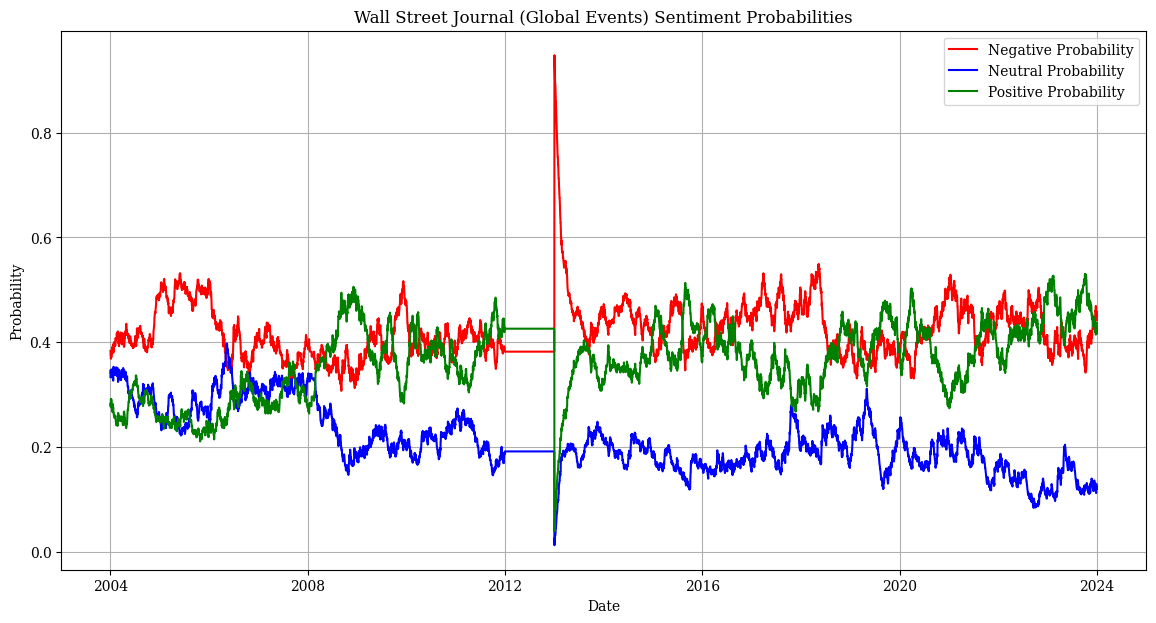

In [55]:
import matplotlib.pyplot as plt

plot_df = full_df[full_df['date'] >= '2004-01-01']

plt.rcParams['font.family'] = 'serif'

plot_df['date'] = pd.to_datetime(plot_df['date'])  # Ensure 'date' is in datetime format

plt.figure(figsize=(14, 7))
plt.plot(plot_df['date'], plot_df['neg_prob_full'], label='Negative Probability', color='red')
plt.plot(plot_df['date'], plot_df['neutral_prob_full'], label='Neutral Probability', color='blue')
plt.plot(plot_df['date'], plot_df['pos_prob_full'], label='Positive Probability', color='green')

plt.title('Wall Street Journal (Global Events) Sentiment Probabilities')
plt.xlabel('Date')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)
plt.show()


In [46]:
full_df.to_csv("wsj_full_signals.csv")